2025-07-01 12:53:55.183927: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-01 12:53:55.195478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751345635.214908   51795 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751345635.225151   51795 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751345635.247041   51795 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

elm__4         itu_marble
elm__2         itu_metal
tx_p_lin.shape (9,)
sqrtP.shape (9, 1, 1)
H_unit.shape (9, 1024, 1024)


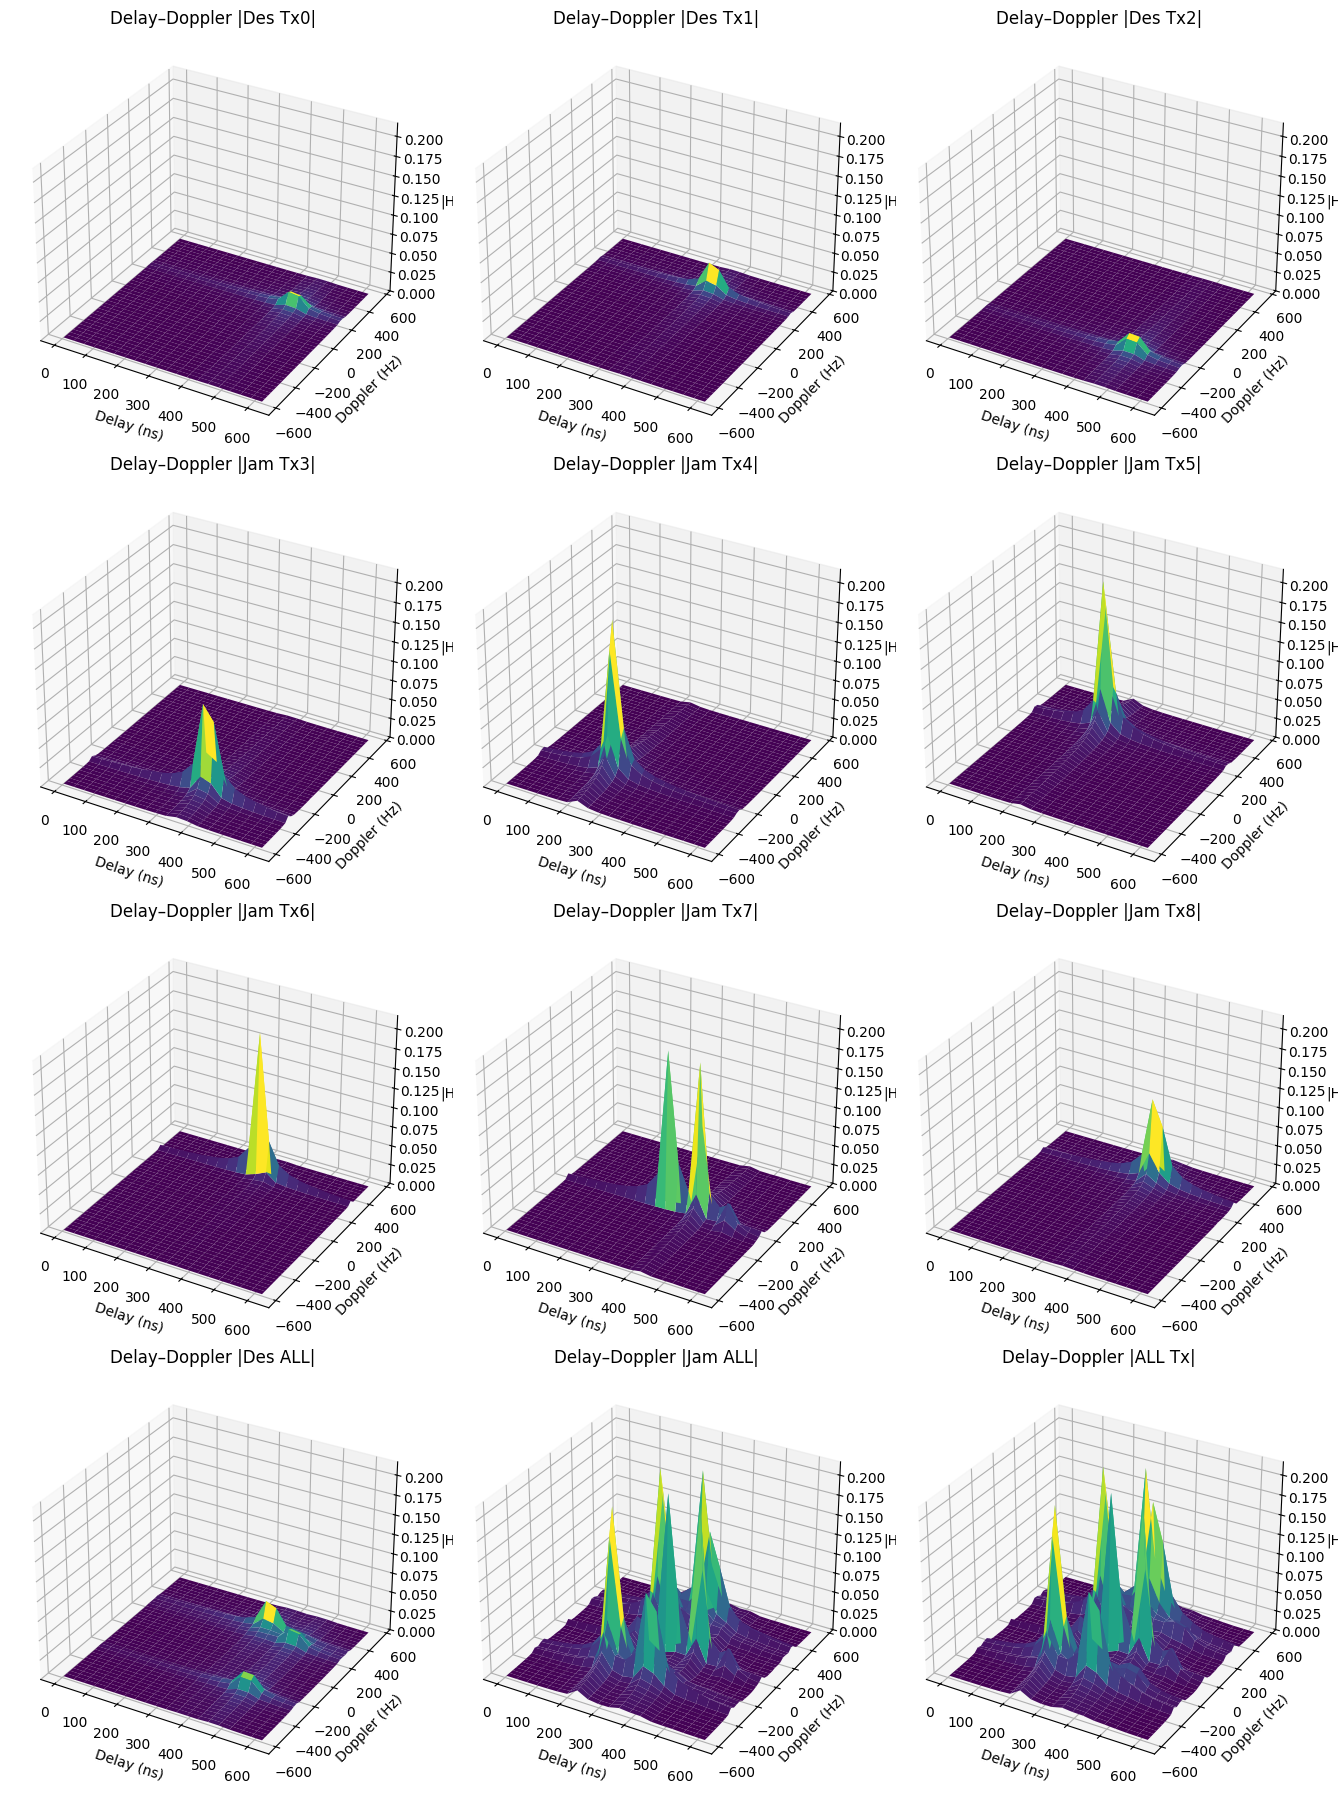

In [1]:
import os, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, PathSolver, subcarrier_frequencies, RadioMapSolver

scene = load_scene("GIS.xml")
for name, obj in scene.objects.items():
    print(f'{name:<15}{obj.radio_material.name}')

# ── 參數區 ───────────────────────────────────────────────────────────────
# 場景與天線
# SCENE_NAME      = sionna.rt.scene.etoile
SCENE_NAME      = "GIS.xml"
TX_ARRAY_CONFIG = dict(num_rows=1, num_cols=1,
                       vertical_spacing=0.5, horizontal_spacing=0.5,
                       pattern="iso", polarization="V")
RX_ARRAY_CONFIG = TX_ARRAY_CONFIG

# 發射機設定： (name, position, orientation, role)

# (name, pos, ori, role, power_dbm)
TX_LIST = [
  ("tx0",  [-100,-100,40], [np.pi*5/6,0,0],     "desired", 30),
  ("tx1",  [-100,  50,40], [np.pi/6,  0,0],     "desired", 30),
  ("tx2",  [ 100,-100,40], [-np.pi/2,0,0],      "desired", 30),
  ("jam1", [ 100, 50, 40], [np.pi/2,  0,0],     "jammer",  40),
  ("jam2", [ 50,  50, 40], [np.pi/2,  0,0],     "jammer",  40),
  ("jam3", [ -50, -50,40], [np.pi/2,  0,0],     "jammer",  40),
  ("jam4", [ -100, 0, 40], [np.pi/2,  0,0],     "jammer",  40),
  ("jam5", [ 0,  -100,40], [np.pi/2,  0,0],     "jammer",  40),
  ("jam6", [ -100, -50,40], [np.pi/2,  0,0],     "jammer",  40),
]

RX_CONFIG      = ("rx", [0,0,40])  # (name, position)

# PathSolver 參數
PATHSOLVER_ARGS = dict(max_depth=3,
                       los=True,
                       specular_reflection=True,
                       diffuse_reflection=False,
                       refraction=False,
                       synthetic_array=False,
                       seed=41)

# RadioMapSolver 參數
RMSOLVER_ARGS   = dict(max_depth=10,
                       cell_size=(1.,1.),
                       samples_per_tx=10**7)

# OFDM / QPSK 參數
N_SYMBOLS       = 1
N_SUBCARRIERS   = 1024
SUBCARRIER_SPACING = 30e3  # Hz
num_ofdm_symbols = 1024 
num_subcarriers = 1024
subcarrier_spacing = 30e3

# 1) 建立場景與天線配置
scene = load_scene(SCENE_NAME)
scene.tx_array = PlanarArray(**TX_ARRAY_CONFIG)
scene.rx_array = PlanarArray(**RX_ARRAY_CONFIG)
for tx_name in scene.transmitters.copy():  
    scene.remove(tx_name)
# 再把所有 receiver name 拿出來，一個個 remove
for rx_name in scene.receivers.copy():
    scene.remove(rx_name)

# 確認都清空了
assert len(scene.transmitters)==0 and len(scene.receivers)==0

# 2) 新增 Tx (含 role 標籤)
def add_tx(scene, name, pos, ori, role, power_dbm):
    tx = Transmitter(name=name, position=pos,
                      power_dbm=power_dbm)
    tx.role = role
    scene.add(tx)
    return tx

# 迴圈時 unpack 五個欄位
for name, pos, ori, role, p_dbm in TX_LIST:
    add_tx(scene, name, pos, ori, role, p_dbm)

# 3) 新增 Rx
rx_name, rx_pos = RX_CONFIG
rx = Receiver(name=rx_name, position=rx_pos)
scene.add(rx)

# 4) 自動分組 indices
tx_names = scene.transmitters
all_txs   = [scene.get(n) for n in tx_names]
idx_des   = [i for i,tx in enumerate(all_txs) if getattr(tx,'role',None)=='desired']
idx_jam   = [i for i,tx in enumerate(all_txs) if getattr(tx,'role',None)=='jammer']

# 5) RadioMap 計算
rm_solver = RadioMapSolver()
rm = rm_solver(scene, **RMSOLVER_ARGS)

# 6) PathSolver 函式
solver = PathSolver()
def solve():
    return solver(scene, **PATHSOLVER_ARGS)

# 7) 計算 CFR
freqs = subcarrier_frequencies(N_SUBCARRIERS, SUBCARRIER_SPACING)
for name in scene.transmitters:
    scene.get(name).velocity = [30, 0, 0]   # 或者 jam1 用 [-30,0,0]
paths = solve()

ofdm_symbol_duration = 1/subcarrier_spacing
delay_resolution = ofdm_symbol_duration/num_subcarriers
doppler_resolution = subcarrier_spacing/num_ofdm_symbols

H_unit = paths.cfr(
    frequencies         = freqs,
    sampling_frequency  = 1/ofdm_symbol_duration,
    num_time_steps      = num_ofdm_symbols,   # ← 讓 Sionna 跑時間演變 (多普勒)
    normalize_delays    = False,
    normalize           = False,
    out_type            = "numpy"
    ).squeeze()           # shape: (num_tx, T, F)

# H_unit = paths.cfr(
#     frequencies         = freqs,
#     sampling_frequency  = 1/ofdm_symbol_duration,
#     num_time_steps      = num_ofdm_symbols,   
#     normalize_delays    = False,
#     normalize           = False,
#     out_type            = "numpy"
#     ).squeeze()           
# print("H_unit.shape", H_unit.shape)
H_all = H_unit.sum(axis=0)
H_des = H_unit[idx_des].sum(axis=0)   # (T, F)
H_jam = H_unit[idx_jam].sum(axis=0)   # (T, F) 
tx_p_lin = 10**(np.array([tx.power_dbm for tx in all_txs]) / 10) / 1e3   
tx_p_lin = np.squeeze(tx_p_lin)  
print("tx_p_lin.shape", tx_p_lin.shape)  
sqrtP    = np.sqrt(tx_p_lin)[:, None, None]            #
print("sqrtP.shape", sqrtP.shape)  
H_unit     = H_unit * sqrtP                                           
print("H_unit.shape", H_unit.shape)  

# 11) 計算 Delay-Doppler圖
def to_delay_doppler(H_tf):
    Hf      = np.fft.fftshift(H_tf, axes=1)            # F shift
    h_delay = np.fft.ifft(Hf, axis=1 , norm="ortho")   # F→delay
    h_dd    = np.fft.fft(h_delay, axis=0 , norm="ortho")# t→doppler
    h_dd    = np.fft.fftshift(h_dd, axes=0)            # doppler shift
    return h_dd
Hdd_list = [to_delay_doppler(H_unit[i]) 
            for i in range(H_unit.shape[0])]   # list 長度 = 6，每項 shape=(1024,1024)

# ========= 2) 每 Tx 轉 DD & 取幅度 =========
Hdd_list = [ np.abs(to_delay_doppler(H_unit[i])) for i in range(H_unit.shape[0]) ]

# ========= 3) 動態組合「個別」與「合成」的網格 =========
grids   = []
labels  = []
doppler_bins = np.arange(-num_ofdm_symbols/2*doppler_resolution,num_ofdm_symbols/2*doppler_resolution,doppler_resolution)
delay_bins = np.arange(0,num_subcarriers*delay_resolution,delay_resolution) / 1e-9
x, y = np.meshgrid(delay_bins, doppler_bins)

offset = 20
x_start = int(num_subcarriers/2)-offset
x_end = int(num_subcarriers/2)+offset
y_start = 0
y_end = offset
x_grid = x[x_start:x_end,y_start:y_end]
y_grid = y[x_start:x_end,y_start:y_end]

# --- Desired 個別 ---
for k,i in enumerate(idx_des):
    Zi = Hdd_list[i][x_start:x_end,y_start:y_end]   # (offset, offset) 小窗
    grids.append(Zi)
    labels.append(f"Des Tx{i}")

# --- Jammer 個別 ---
for k,i in enumerate(idx_jam):
    Zi = Hdd_list[i][x_start:x_end,y_start:y_end]
    grids.append(Zi)
    labels.append(f"Jam Tx{i}")

# --- Desired All ---
if idx_des:
    Z_des_all = np.sum([Hdd_list[i] for i in idx_des], axis=0)
    grids.append(Z_des_all[x_start:x_end,y_start:y_end])
    labels.append("Des ALL")

# --- Jammer All ---
if idx_jam:
    Z_jam_all = np.sum([Hdd_list[i] for i in idx_jam], axis=0)
    grids.append(Z_jam_all[x_start:x_end,y_start:y_end])
    labels.append("Jam ALL")

# --- All Tx ---
Z_all = np.sum(Hdd_list, axis=0)
grids.append(Z_all[x_start:x_end,y_start:y_end])
labels.append("ALL Tx")

# ========= 4) 統一 Z 軸 =========
z_min = 0
z_max = max(g.max() for g in grids) * 1.05

# ========= 5) 自動排版 (每列最多 3 張) =========
n_plots  = len(grids)
cols     = 3
rows     = int(np.ceil(n_plots / cols))
figsize  = (cols*4.5, rows*4.5)

fig = plt.figure(figsize=figsize)

for idx,(Z,label) in enumerate(zip(grids, labels), start=1):
    ax = fig.add_subplot(rows, cols, idx, projection='3d')
    ax.plot_surface(x_grid, y_grid, Z, cmap='viridis', edgecolor='none')
    ax.set_title(f"Delay–Doppler |{label}|", pad=8)
    ax.set_xlabel("Delay (ns)"); ax.set_ylabel("Doppler (Hz)"); ax.set_zlabel("|H|")
    ax.set_zlim(z_min, z_max)
    # ax.view_init(elev=53, azim=-32)

plt.tight_layout()
plt.show()